In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [2]:
# Load the dataset
df = pd.read_csv('/content/Grocery_Inventory_and_Sales_Dataset.csv')

# Initial data exploration
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())
print("\nMissing values per column:")
print(df.isnull().sum())

Dataset shape: (990, 16)

First 5 rows:
    Product_ID     Product_Name             Catagory  Supplier_ID Supplier_Name  Stock_Quantity  Reorder_Level  Reorder_Quantity Unit_Price Date_Received Last_Order_Date Expiration_Date      Warehouse_Location  Sales_Volume  Inventory_Turnover_Rate        Status
0  29-205-1132       Sushi Rice      Grains & Pulses  38-037-1699     Jaxnation              22             72                70     $4.50      8/16/2024       6/29/2024       9/19/2024        48 Del Sol Trail            32                       19  Discontinued
1  40-681-9981   Arabica Coffee            Beverages  54-470-2479       Feedmix              45             77                 2    $20.00      11/1/2024       5/29/2024        5/8/2024            36 3rd Place            85                        1  Discontinued
2  06-955-3428       Black Rice      Grains & Pulses  54-031-2945        Vinder              30             38                83     $6.00       8/3/2024       6/10/2024  

In [3]:
# Clean the Unit_Price column by removing $ and converting to float
df['Unit_Price'] = df['Unit_Price'].str.replace('$', '').astype(float)

# Convert date columns to datetime
date_cols = ['Date_Received', 'Last_Order_Date', 'Expiration_Date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Handle missing values
df.fillna({
    'Stock_Quantity': df['Stock_Quantity'].median(),
    'Reorder_Level': df['Reorder_Level'].median(),
    'Reorder_Quantity': df['Reorder_Quantity'].median(),
    'Unit_Price': df['Unit_Price'].median(),
    'Sales_Volume': df['Sales_Volume'].median(),
    'Inventory_Turnover_Rate': df['Inventory_Turnover_Rate'].median()
}, inplace=True)

# Drop rows with critical missing dates
df.dropna(subset=['Date_Received', 'Expiration_Date'], inplace=True)

# Calculate days until expiration
df['Days_Until_Expiration'] = (df['Expiration_Date'] - pd.to_datetime('today')).dt.days

# Create a binary target variable for dead stock (1 = dead stock, 0 = not dead stock)
# Define dead stock as items with Inventory_Turnover_Rate below 10th percentile
threshold = df['Inventory_Turnover_Rate'].quantile(0.1)
df['Dead_Stock'] = (df['Inventory_Turnover_Rate'] <= threshold).astype(int)

# Encode categorical variables
cat_cols = ['Catagory', 'Warehouse_Location', 'Status']
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

print("\nData after cleaning and preprocessing:")
print(df.head())


Data after cleaning and preprocessing:
    Product_ID     Product_Name  Catagory  Supplier_ID Supplier_Name  Stock_Quantity  Reorder_Level  Reorder_Quantity  Unit_Price Date_Received Last_Order_Date Expiration_Date  Warehouse_Location  Sales_Volume  Inventory_Turnover_Rate  Status  Days_Until_Expiration  Dead_Stock
0  29-205-1132       Sushi Rice         4  38-037-1699     Jaxnation              22             72                70         4.5    2024-08-16      2024-06-29      2024-09-19                 486            32                       19       2                   -253           0
1  40-681-9981   Arabica Coffee         1  54-470-2479       Feedmix              45             77                 2        20.0    2024-11-01      2024-05-29      2024-05-08                 365            85                        1       2                   -387           1
2  06-955-3428       Black Rice         4  54-031-2945        Vinder              30             38                83         

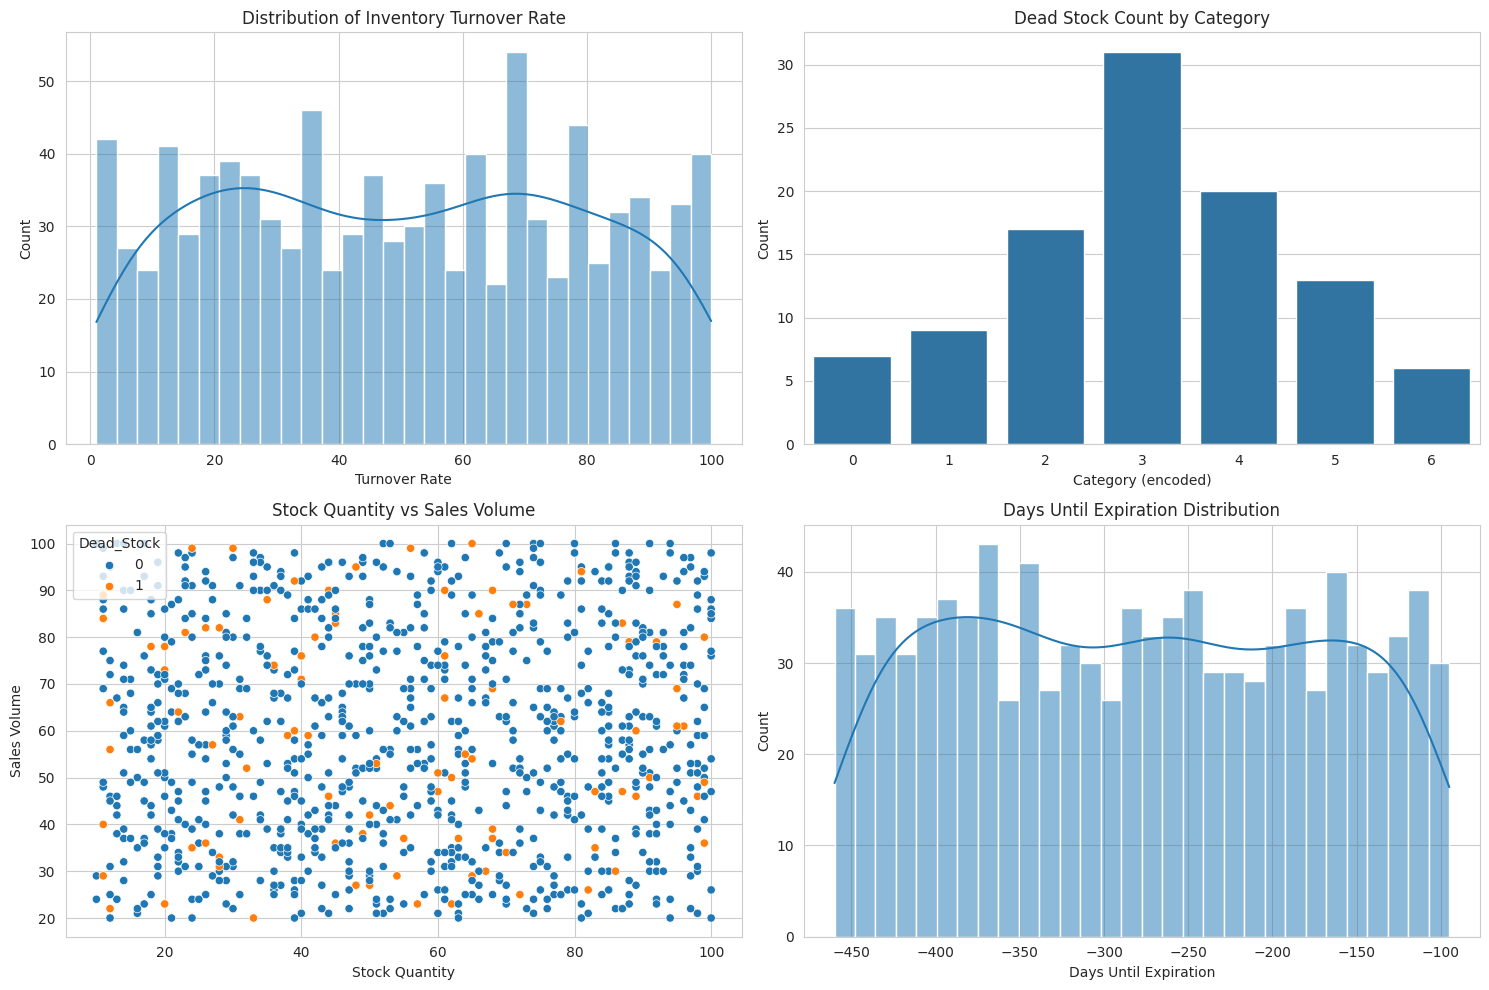

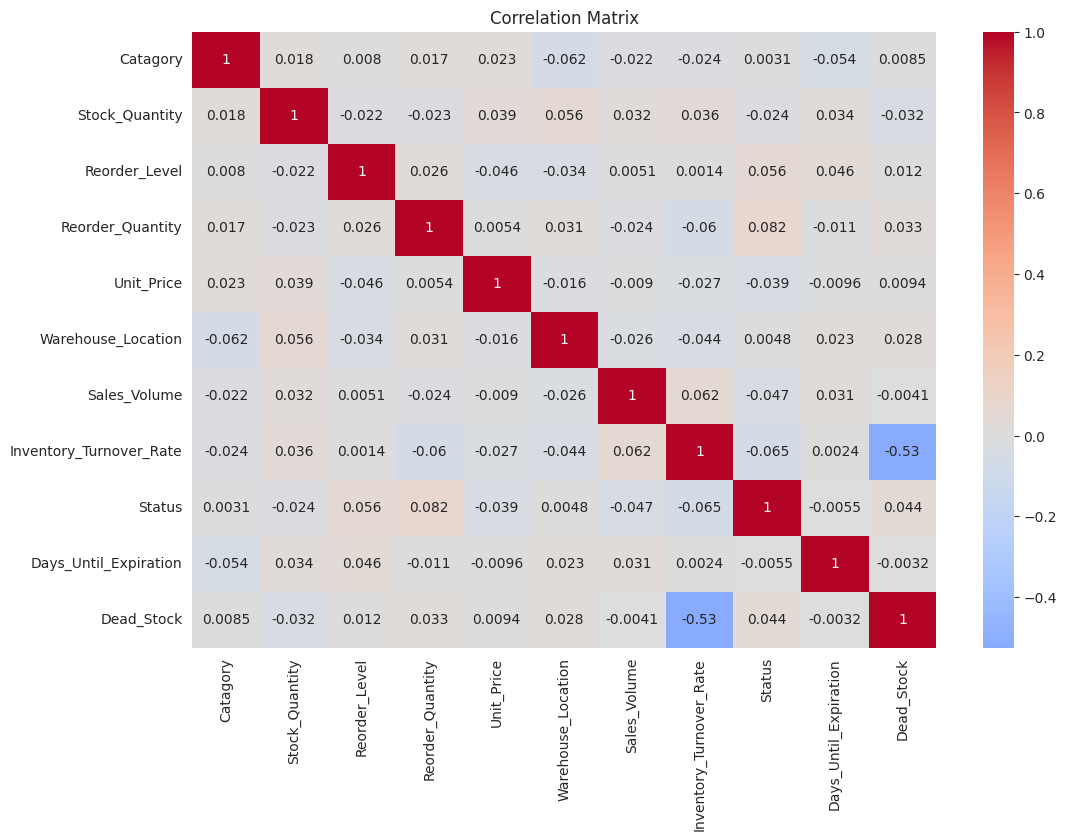

In [4]:
# Set style for visualizations
sns.set_style('whitegrid')
plt.figure(figsize=(15, 10))

# Distribution of Inventory Turnover Rate
plt.subplot(2, 2, 1)
sns.histplot(df['Inventory_Turnover_Rate'], bins=30, kde=True)
plt.title('Distribution of Inventory Turnover Rate')
plt.xlabel('Turnover Rate')
plt.ylabel('Count')

# Dead stock by category
plt.subplot(2, 2, 2)
dead_by_category = df[df['Dead_Stock'] == 1]['Catagory'].value_counts()
sns.barplot(x=dead_by_category.index, y=dead_by_category.values)
plt.title('Dead Stock Count by Category')
plt.xlabel('Category (encoded)')
plt.ylabel('Count')

# Stock quantity vs sales volume
plt.subplot(2, 2, 3)
sns.scatterplot(x='Stock_Quantity', y='Sales_Volume', hue='Dead_Stock', data=df)
plt.title('Stock Quantity vs Sales Volume')
plt.xlabel('Stock Quantity')
plt.ylabel('Sales Volume')

# Days until expiration distribution
plt.subplot(2, 2, 4)
sns.histplot(df['Days_Until_Expiration'], bins=30, kde=True)
plt.title('Days Until Expiration Distribution')
plt.xlabel('Days Until Expiration')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

In [5]:
# Calculate time since last order
df['Days_Since_Last_Order'] = (pd.to_datetime('today') - df['Last_Order_Date']).dt.days

# Calculate stock to sales ratio
df['Stock_to_Sales_Ratio'] = df['Stock_Quantity'] / (df['Sales_Volume'] + 1)  # +1 to avoid division by zero

# Calculate reorder level compliance
df['Reorder_Compliance'] = df['Stock_Quantity'] / df['Reorder_Level']

# Create urgency score (combining expiration and turnover)
df['Urgency_Score'] = (1 / (df['Days_Until_Expiration'] + 1)) * (1 / (df['Inventory_Turnover_Rate'] + 1))

# Create features for machine learning
features = ['Stock_Quantity', 'Reorder_Level', 'Reorder_Quantity', 'Unit_Price',
            'Sales_Volume', 'Inventory_Turnover_Rate', 'Days_Until_Expiration',
            'Days_Since_Last_Order', 'Stock_to_Sales_Ratio', 'Reorder_Compliance',
            'Urgency_Score', 'Catagory', 'Warehouse_Location']

X = df[features]
y = df['Dead_Stock']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Model Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       176
           1       1.00      1.00      1.00        22

    accuracy                           1.00       198
   macro avg       1.00      1.00      1.00       198
weighted avg       1.00      1.00      1.00       198

Accuracy: 1.0


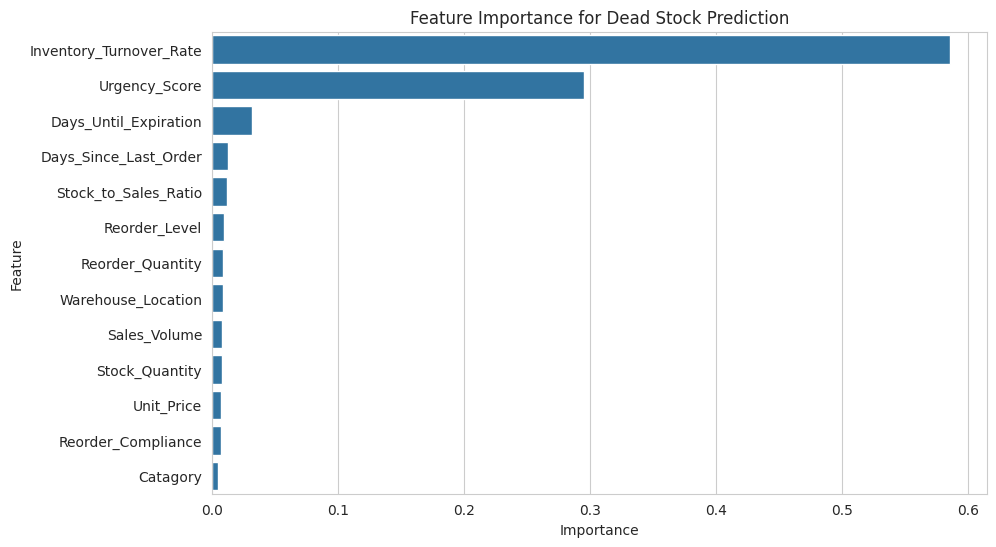

In [6]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test_scaled)

# Evaluate model
print("Model Evaluation:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Dead Stock Prediction')
plt.show()

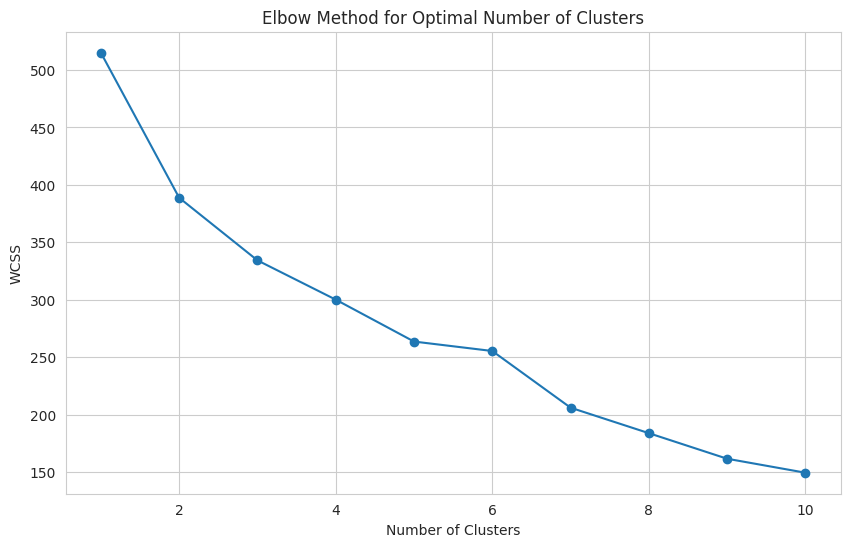


Cluster Analysis:
                   Unit_Price  Stock_Quantity  Days_Until_Expiration  Inventory_Turnover_Rate  Stock_to_Sales_Ratio
Clearance_Cluster                                                                                                  
0                    4.784211       77.894737            -247.605263                 5.684211              1.780213
1                    5.716667       34.277778            -346.444444                 3.750000              0.619241
2                    8.311034       44.103448            -242.517241                 8.413793              0.693700


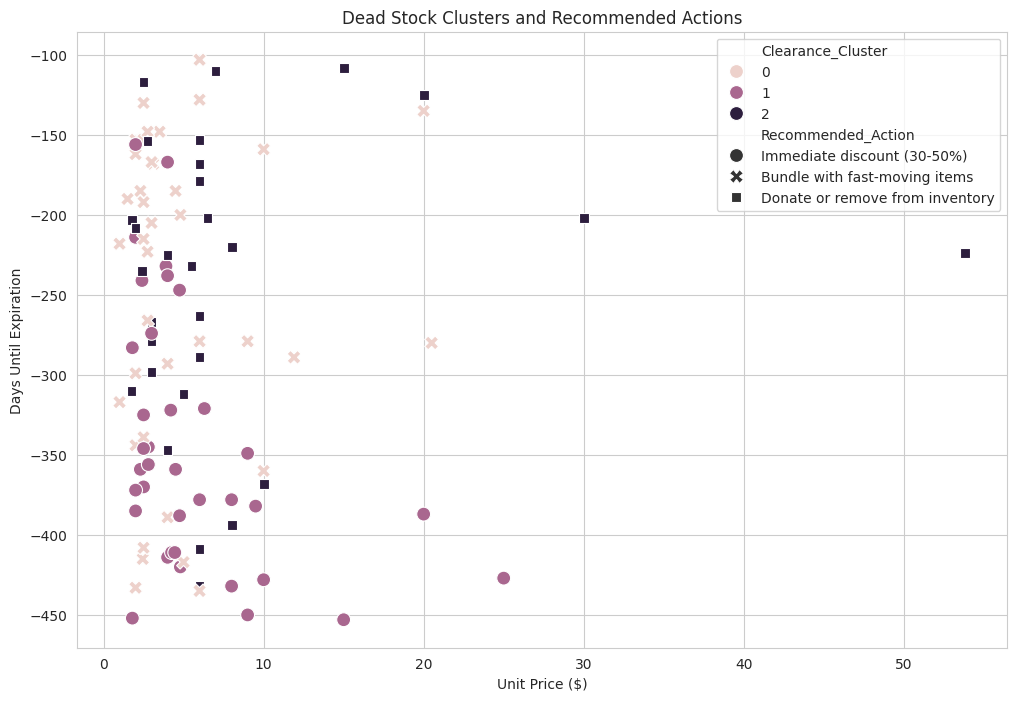

In [7]:
# Prepare data for clustering (focus on dead stock)
dead_stock = df[df['Dead_Stock'] == 1]
cluster_features = ['Unit_Price', 'Stock_Quantity', 'Days_Until_Expiration',
                   'Inventory_Turnover_Rate', 'Stock_to_Sales_Ratio']

X_cluster = dead_stock[cluster_features]

# Standardize data
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# Determine optimal number of clusters using elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_cluster_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Apply K-means clustering
n_clusters = 3  # Based on elbow method
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
dead_stock['Clearance_Cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Analyze clusters
cluster_analysis = dead_stock.groupby('Clearance_Cluster')[cluster_features].mean()
print("\nCluster Analysis:")
print(cluster_analysis)

# Assign clearance strategies based on clusters
clearance_strategies = {
    0: 'Bundle with fast-moving items',
    1: 'Immediate discount (30-50%)',
    2: 'Donate or remove from inventory'
}

dead_stock['Recommended_Action'] = dead_stock['Clearance_Cluster'].map(clearance_strategies)

# Visualize clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Unit_Price', y='Days_Until_Expiration',
                hue='Clearance_Cluster', style='Recommended_Action',
                data=dead_stock, s=100)
plt.title('Dead Stock Clusters and Recommended Actions')
plt.xlabel('Unit Price ($)')
plt.ylabel('Days Until Expiration')
plt.show()

In [8]:
# Create early warning flags for active items
active_items = df[df['Status'] == label_encoders['Status'].transform(['Active'])[0]]

# Calculate warning score (combination of features that might indicate future dead stock)
active_items['Warning_Score'] = (
    0.3 * (1 / (active_items['Inventory_Turnover_Rate'] + 1)) +
    0.2 * (active_items['Stock_to_Sales_Ratio'] / active_items['Stock_to_Sales_Ratio'].max()) +
    0.2 * (active_items['Days_Since_Last_Order'] / active_items['Days_Since_Last_Order'].max()) +
    0.3 * (1 / (active_items['Days_Until_Expiration'] + 1))
)

# Normalize warning score
active_items['Warning_Score'] = (active_items['Warning_Score'] - active_items['Warning_Score'].min()) / \
                               (active_items['Warning_Score'].max() - active_items['Warning_Score'].min())

# Flag items with warning score above 75th percentile
warning_threshold = active_items['Warning_Score'].quantile(0.75)
active_items['Early_Warning'] = (active_items['Warning_Score'] > warning_threshold).astype(int)

# Add to main dataframe
df = df.merge(active_items[['Product_ID', 'Warning_Score', 'Early_Warning']],
              on='Product_ID', how='left')
df['Warning_Score'].fillna(0, inplace=True)
df['Early_Warning'].fillna(0, inplace=True)

print("\nItems with early warnings:")
print(df[df['Early_Warning'] == 1][['Product_ID', 'Product_Name', 'Warning_Score']].sort_values('Warning_Score', ascending=False).head())


Items with early warnings:
      Product_ID     Product_Name  Warning_Score
502  38-049-9319  Oatmeal Biscuit       1.000000
834  19-112-1616          Lettuce       0.982681
877  80-441-7249        Wild Rice       0.940111
105  64-478-4745            Lemon       0.932785
58   41-729-5410         Sardines       0.912553


In [10]:
# Fix column name typo if necessary
if 'Catagory' in df.columns:
    df.rename(columns={'Catagory': 'Category'}, inplace=True)

# Create Recommended_Action column
def recommend_action(row):
    if row['Inventory_Turnover_Rate'] < 1:
        return 'Discount or Remove'
    elif row['Days_Until_Expiration'] < 30:
        return 'Urgent Promotion'
    else:
        return 'Monitor'

df['Recommended_Action'] = df.apply(recommend_action, axis=1)

# Create summary metrics for dashboard
total_inventory_value = (df['Stock_Quantity'] * df['Unit_Price']).sum()
dead_stock_value = (df[df['Dead_Stock'] == 1]['Stock_Quantity'] * df[df['Dead_Stock'] == 1]['Unit_Price']).sum()
warning_stock_value = (df[df['Early_Warning'] == 1]['Stock_Quantity'] * df[df['Early_Warning'] == 1]['Unit_Price']).sum()

summary_metrics = {
    'Total Inventory Value': f"${total_inventory_value:,.2f}",
    'Dead Stock Value': f"${dead_stock_value:,.2f}",
    'Potential Dead Stock Value': f"${warning_stock_value:,.2f}",
    '% of Inventory as Dead Stock': f"{dead_stock_value / total_inventory_value * 100:.2f}%",
    'Number of Dead Stock Items': int(df['Dead_Stock'].sum()),
    'Number of Early Warning Items': int(df['Early_Warning'].sum())
}

print("\nInventory Summary Metrics:")
for k, v in summary_metrics.items():
    print(f"{k}: {v}")

# Create actionable reports
dead_stock_report = df[df['Dead_Stock'] == 1][[
    'Product_ID', 'Product_Name', 'Category', 'Stock_Quantity',
    'Unit_Price', 'Days_Until_Expiration', 'Inventory_Turnover_Rate',
    'Recommended_Action'
]].sort_values('Days_Until_Expiration')

early_warning_report = df[df['Early_Warning'] == 1][[
    'Product_ID', 'Product_Name', 'Category', 'Stock_Quantity',
    'Unit_Price', 'Days_Until_Expiration', 'Inventory_Turnover_Rate',
    'Warning_Score'
]].sort_values('Warning_Score', ascending=False)

print("\nTop 5 Dead Stock Items Requiring Action:")
print(dead_stock_report.head())

print("\nTop 5 Items with Early Warnings:")
print(early_warning_report.head())



Inventory Summary Metrics:
Total Inventory Value: $332,654.71
Dead Stock Value: $34,184.75
Potential Dead Stock Value: $33,074.07
% of Inventory as Dead Stock: 10.28%
Number of Dead Stock Items: 103
Number of Early Warning Items: 83

Top 5 Dead Stock Items Requiring Action:
      Product_ID    Product_Name  Category  Stock_Quantity  Unit_Price  Days_Until_Expiration  Inventory_Turnover_Rate Recommended_Action
65   14-844-4138    Black Coffee         1              61        15.0                   -453                        6   Urgent Promotion
807  69-895-3397        Cucumber         3              28         1.8                   -452                        9   Urgent Promotion
419  92-995-8689  Cheddar Cheese         2              31         9.0                   -450                        7   Urgent Promotion
269  09-536-2626       Olive Oil         5              83         6.0                   -435                        7   Urgent Promotion
481  73-751-4393           Onion  

In [11]:
# Save all reports and predictions
df.to_csv('inventory_with_predictions.csv', index=False)
dead_stock_report.to_csv('dead_stock_actions.csv', index=False)
early_warning_report.to_csv('early_warnings.csv', index=False)

# Implementation recommendations
print("\nImplementation Recommendations:")
print("1. Integrate this system with your existing inventory management software")
print("2. Schedule weekly runs of the analysis to update dead stock identification")
print("3. Create automated alerts for items crossing the dead stock threshold")
print("4. Implement the recommended clearance strategies systematically")
print("5. Review early warning items monthly to prevent future dead stock accumulation")
print("6. Monitor the system's performance monthly using the success metrics")

# Success metrics tracking plan
print("\nSuccess Metrics Tracking Plan:")
print("- Monthly dead stock value reduction target: 15% reduction in first 3 months")
print("- Inventory turnover rate improvement target: 20% improvement in 6 months")
print("- Warehouse space utilization improvement: Measure freed-up space monthly")
print("- Reduction in write-offs: Track monthly write-off amounts")
print("- Improvement in cash flow: Monitor freed-up capital monthly")


Implementation Recommendations:
1. Integrate this system with your existing inventory management software
2. Schedule weekly runs of the analysis to update dead stock identification
3. Create automated alerts for items crossing the dead stock threshold
4. Implement the recommended clearance strategies systematically
5. Review early warning items monthly to prevent future dead stock accumulation
6. Monitor the system's performance monthly using the success metrics

Success Metrics Tracking Plan:
- Monthly dead stock value reduction target: 15% reduction in first 3 months
- Inventory turnover rate improvement target: 20% improvement in 6 months
- Warehouse space utilization improvement: Measure freed-up space monthly
- Reduction in write-offs: Track monthly write-off amounts
- Improvement in cash flow: Monitor freed-up capital monthly


In [12]:
# Conceptual code for model deployment (actual implementation would use Flask/FastAPI etc.)
class DeadStockPredictor:
    def __init__(self, model, scaler, label_encoders):
        self.model = model
        self.scaler = scaler
        self.label_encoders = label_encoders

    def preprocess(self, new_data):
        """Preprocess new incoming data"""
        # Apply the same preprocessing as training data
        new_data = new_data.copy()
        new_data['Unit_Price'] = new_data['Unit_Price'].str.replace('$', '').astype(float)

        for col in ['Date_Received', 'Last_Order_Date', 'Expiration_Date']:
            new_data[col] = pd.to_datetime(new_data[col], errors='coerce')

        new_data['Days_Until_Expiration'] = (new_data['Expiration_Date'] - pd.to_datetime('today')).dt.days
        new_data['Days_Since_Last_Order'] = (pd.to_datetime('today') - new_data['Last_Order_Date']).dt.days
        new_data['Stock_to_Sales_Ratio'] = new_data['Stock_Quantity'] / (new_data['Sales_Volume'] + 1)
        new_data['Reorder_Compliance'] = new_data['Stock_Quantity'] / new_data['Reorder_Level']
        new_data['Urgency_Score'] = (1 / (new_data['Days_Until_Expiration'] + 1)) * (1 / (new_data['Inventory_Turnover_Rate'] + 1))

        # Encode categorical variables
        for col in ['Catagory', 'Warehouse_Location', 'Status']:
            le = self.label_encoders[col]
            new_data[col] = le.transform(new_data[col].astype(str))

        return new_data

    def predict(self, new_data):
        """Make predictions on new data"""
        processed_data = self.preprocess(new_data)
        features = processed_data[features]  # Use the same features as training

        # Scale features
        scaled_features = self.scaler.transform(features)

        # Make predictions
        predictions = self.model.predict(scaled_features)
        probabilities = self.model.predict_proba(scaled_features)[:, 1]

        # Add predictions to dataframe
        new_data['Dead_Stock_Probability'] = probabilities
        new_data['Dead_Stock_Prediction'] = predictions

        return new_data

# Conceptual usage:
# predictor = DeadStockPredictor(rf_model, scaler, label_encoders)
# new_data = pd.read_csv('new_inventory_data.csv')
# predictions = predictor.predict(new_data)

In [13]:
# Recommendations for continuous improvement
print("\nContinuous Improvement Plan:")
print("1. Data Quality:")
print("   - Implement data validation checks for new inventory entries")
print("   - Regularly audit data sources for accuracy")
print("   - Establish data governance policies")

print("\n2. Model Retraining:")
print("   - Retrain model quarterly with new data")
print("   - Monitor model performance metrics monthly")
print("   - Implement A/B testing for new model versions")

print("\n3. Process Optimization:")
print("   - Gather feedback from inventory managers on recommendations")
print("   - Adjust clearance strategies based on actual results")
print("   - Refine early warning thresholds based on outcomes")

print("\n4. System Integration:")
print("   - Integrate with POS system for real-time sales data")
print("   - Connect with procurement system for better ordering decisions")
print("   - Link with financial systems to track impact on cash flow")


Continuous Improvement Plan:
1. Data Quality:
   - Implement data validation checks for new inventory entries
   - Regularly audit data sources for accuracy
   - Establish data governance policies

2. Model Retraining:
   - Retrain model quarterly with new data
   - Monitor model performance metrics monthly
   - Implement A/B testing for new model versions

3. Process Optimization:
   - Gather feedback from inventory managers on recommendations
   - Adjust clearance strategies based on actual results
   - Refine early warning thresholds based on outcomes

4. System Integration:
   - Integrate with POS system for real-time sales data
   - Connect with procurement system for better ordering decisions
   - Link with financial systems to track impact on cash flow
